2024-06-20 20:33:46.664605: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:33:48.297385: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:33:48.304109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 20:33:50.541352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
40/40 [==============================] - 1s 6ms/step - loss: 178124783616.0000 - val_loss: 143749447680.0000
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 178123276288.0000 - val_loss: 143747416064.0000
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 178118705152.0000 - val_loss: 143741386752.0000
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 178107416576.0000 - val_loss: 143728721920.0000
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 178085117952.0000 - val_loss: 143705948160.0000
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 178048630784.0000 - val_loss: 143671164928.0000
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 177994727424.0000 - val_loss: 143618113536.0000
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 177914806272.0000 - val_loss: 143546138624.0000
Epoch 9/100
40/40 [=============

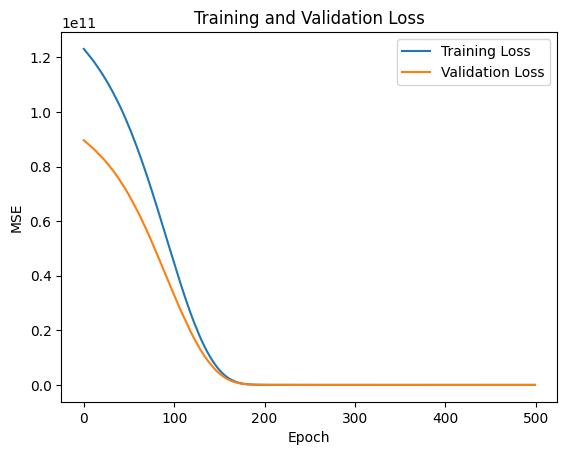

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Load data
df = pd.read_csv('dummy_vet_specialties_data.csv')

# Convert sign_in_time to datetime
df['sign_in_time'] = pd.to_datetime(df['sign_in_time'])

# Split specialty into a list
df['specialty'] = df['specialty'].apply(lambda x: x.split(', '))

# Encode specialties
mlb = MultiLabelBinarizer()
specialties_encoded = mlb.fit_transform(df['specialty'])
specialties_encoded_df = pd.DataFrame(specialties_encoded, columns=mlb.classes_)

# Combine encoded specialties with the original data
df = pd.concat([df.drop('specialty', axis=1), specialties_encoded_df], axis=1)

# Normalize data
scaler = MinMaxScaler()
df[['rating', 'num_rating']] = scaler.fit_transform(df[['rating', 'num_rating']])

# Identify new doctors (joined within the last 7 days)
current_time = datetime.now()
df['is_new'] = df['sign_in_time'].apply(lambda x: (current_time - x).days <= 7).astype(int)

# Define weights
weight_rating = 0.9
weight_num_rating = 0.1
weight_new_doctor = 1e6  # A very large weight to prioritize new doctors

# Calculate weighted score
df['weighted_score'] = (weight_rating * df['rating']) + (weight_num_rating * df['num_rating']) + (weight_new_doctor * df['is_new'])

# Split data into features and target
X = df.drop(['vet_name', 'sign_in_time', 'weighted_score'], axis=1).values
y = df['weighted_score'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Get the history of the model's training
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

def recommend_vets(desired_specialty, save_to_csv=False, csv_filename='recommended_vets.csv'):
    # Encode the desired specialty
    desired_specialty_encoded = mlb.transform([[desired_specialty]]).flatten()

    # Filter data for desired specialty
    filtered_df = df.loc[(specialties_encoded_df.values @ desired_specialty_encoded) > 0].copy()

    # Prepare input data for prediction
    input_data = filtered_df.drop(['vet_name', 'sign_in_time', 'weighted_score'], axis=1).values

    # Ensure input_data is of type float32 for TensorFlow
    input_data = input_data.astype('float32')

    # Predict scores using the model
    scores = model.predict(input_data)

    # Add scores to the filtered dataframe
    filtered_df.loc[:, 'score'] = scores.flatten()

    # Add "NEWCOMER" identifier to new doctors in a separate column
    filtered_df['newcomer_status'] = filtered_df['is_new'].apply(lambda x: 'NEWCOMER' if x == 1 else 'EXISTING')

    # Get recommendations
    recommendations = filtered_df.sort_values(by='score', ascending=False)

    # Revert normalization for rating and num_rating before displaying
    recommendations[['rating', 'num_rating']] = scaler.inverse_transform(recommendations[['rating', 'num_rating']])
    recommendations['specialties'] = recommendations[mlb.classes_].apply(lambda row: ', '.join(row.index[row.astype(bool)]), axis=1)

    current_date = datetime.now().strftime("%d_%m_%Y")
    folder_path = os.path.join(current_date, "recommendations")
    if save_to_csv:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if desired_specialty == "reptile":
            recommendations.to_csv(os.path.join(folder_path, "reptile.csv"), index=False)
        elif desired_specialty == "pet":
            recommendations.to_csv(os.path.join(folder_path, "pet.csv"), index=False)
        elif desired_specialty == "bird":
            recommendations.to_csv(os.path.join(folder_path, "bird.csv"), index=False)
        elif desired_specialty == "exotic":
            recommendations.to_csv(os.path.join(folder_path, "exotic.csv"), index=False)
        elif desired_specialty == "cattle":
            recommendations.to_csv(os.path.join(folder_path, "cattle.csv"), index=False)
        elif desired_specialty == "aquatic":
            recommendations.to_csv(os.path.join(folder_path, "aquatic.csv"), index=False)

    return recommendations[['newcomer_status', 'vet_name', 'specialties', 'rating', 'num_rating', 'score']]


In [2]:
# Example usage
desired_specialty = 'reptile'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

19/19 [==============================] - 0s 1ms/step
    newcomer_status                              vet_name  \
596        NEWCOMER  vet_94c9753539dc441c9dde58ca1f341295   
388        NEWCOMER  vet_6374fa53fe054006b926b5181b35da97   
971        NEWCOMER  vet_f706bc07913b4f3daf0e9333564a9fbc   
717        NEWCOMER  vet_b530116a74fa4c56908d71a53ce225c6   
832        NEWCOMER  vet_d49a678c7a54458588f5221c0a64c7e6   
..              ...                                   ...   
245        EXISTING  vet_3f78194d3f7c45dbac1e8cf51c4b3e18   
579        EXISTING  vet_9109a78056c6497c9cba0222030dd2f8   
861        EXISTING  vet_dd720816e13642b994d4d74a1c0220d7   
106        EXISTING  vet_1a66c6bb623b46c598591f1602afbe65   
493        EXISTING  vet_7ea1d854af934265861583dc04ac16e2   

                                     specialties  rating  num_rating  \
596                                      reptile     4.2        77.0   
388                                      reptile     4.5       175.0  

In [3]:
# Example usage
desired_specialty = 'pet'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

 1/20 [>.............................] - ETA: 0s

20/20 [==============================] - 0s 1ms/step
    newcomer_status                              vet_name  \
248        NEWCOMER  vet_3fd192bd997340fc957aea23e898d66a   
795        NEWCOMER  vet_ca0ce9ab82204e7ba96379786759773e   
691        NEWCOMER  vet_adeb1593900a4622a4c7fc35075536c3   
111        NEWCOMER  vet_1c938d41950348afa7057d2eebff7baa   
530        NEWCOMER  vet_8511f89655ef4186aab670a7392c676b   
..              ...                                   ...   
385        EXISTING  vet_62bc1618cb5c4c418bc8dc72bd827628   
866        EXISTING  vet_ddfea15bdfc94b59960cc8375f2fc0b9   
305        EXISTING  vet_4c2f30138bb4466d86b7994f64ab8db4   
443        EXISTING  vet_71110656e8ba49428b5b932a1d125074   
186        EXISTING  vet_30941087589b4326847643e61ae4094b   

                            specialties  rating  num_rating         score  
248                        pet, reptile     4.9        10.0  1.000008e+06  
795                cattle, pet, reptile     4.1       176.0  1

In [4]:
# Example usage
desired_specialty = 'exotic'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

20/20 [==============================] - 0s 1ms/step
    newcomer_status                              vet_name  \
660        NEWCOMER  vet_a54e1d45c9ce4ec7abb4ffaa7aced02a   
540        NEWCOMER  vet_87d61481d95e4209be5cf01a486e24f0   
405        NEWCOMER  vet_66ebc7295c834b36a49ce50273a1b573   
661        NEWCOMER  vet_a55c0a742fa24401b9ea68af875d6e30   
830        NEWCOMER  vet_d40cfa1de5c4456c8733a17220e0e02f   
..              ...                                   ...   
385        EXISTING  vet_62bc1618cb5c4c418bc8dc72bd827628   
866        EXISTING  vet_ddfea15bdfc94b59960cc8375f2fc0b9   
305        EXISTING  vet_4c2f30138bb4466d86b7994f64ab8db4   
443        EXISTING  vet_71110656e8ba49428b5b932a1d125074   
186        EXISTING  vet_30941087589b4326847643e61ae4094b   

                            specialties  rating  num_rating         score  
660             cattle, exotic, reptile     4.0       165.0  1.000006e+06  
540        cattle, exotic, pet, reptile     5.0       140.0  1

In [5]:
# Example usage
desired_specialty = 'aquatic'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

17/17 [==============================] - 0s 1ms/step


    newcomer_status                              vet_name  \
598        NEWCOMER  vet_951f2d0e57514f19bcf82e177410901f   
364        NEWCOMER  vet_5b7f9a13b0184ee297e45dc0e65a355d   
406        NEWCOMER  vet_66f453c1fee04c76a2057d9061d56478   
289        NEWCOMER  vet_48359eb969cd435ebb07ac77a084e53e   
951        NEWCOMER  vet_f24688218c724607bda4daaf16ff3b06   
..              ...                                   ...   
385        EXISTING  vet_62bc1618cb5c4c418bc8dc72bd827628   
866        EXISTING  vet_ddfea15bdfc94b59960cc8375f2fc0b9   
305        EXISTING  vet_4c2f30138bb4466d86b7994f64ab8db4   
443        EXISTING  vet_71110656e8ba49428b5b932a1d125074   
186        EXISTING  vet_30941087589b4326847643e61ae4094b   

                            specialties  rating  num_rating         score  
598            aquatic, cattle, reptile     2.8       115.0  1.000006e+06  
364                             aquatic     4.7       186.0  1.000005e+06  
406               aquatic, pet, reptile

In [6]:
# Example usage
desired_specialty = 'cattle'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

17/17 [==============================] - 0s 1ms/step


    newcomer_status                              vet_name  \
755        NEWCOMER  vet_bd5f4c6c34504b26ab2f5bb03c9c3a19   
536        NEWCOMER  vet_87086cbfc85d4b98849c3f521a706934   
204        NEWCOMER  vet_35d868c5a13c4a48bef7ef3926adbc7c   
795        NEWCOMER  vet_ca0ce9ab82204e7ba96379786759773e   
691        NEWCOMER  vet_adeb1593900a4622a4c7fc35075536c3   
..              ...                                   ...   
603        EXISTING  vet_968e0c17350541daa6fb319973691cd2   
480        EXISTING  vet_7c3ff1e7bd6e4f3c9e6d57ee9af51c90   
194        EXISTING  vet_3301def3d56d49dcb1ce2fab97cbf008   
385        EXISTING  vet_62bc1618cb5c4c418bc8dc72bd827628   
305        EXISTING  vet_4c2f30138bb4466d86b7994f64ab8db4   

                            specialties  rating  num_rating         score  
755                              cattle     4.6        10.0  1.000008e+06  
536                              cattle     4.4        48.0  1.000008e+06  
204                              cattle

In [7]:
# Example usage
desired_specialty = 'bird'
top_vets = recommend_vets(desired_specialty, save_to_csv=True)
print(top_vets)

 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
    newcomer_status                              vet_name  \
691        NEWCOMER  vet_adeb1593900a4622a4c7fc35075536c3   
111        NEWCOMER  vet_1c938d41950348afa7057d2eebff7baa   
530        NEWCOMER  vet_8511f89655ef4186aab670a7392c676b   
442        NEWCOMER  vet_70e1f9976055422c9919f2dbba1cd724   
960        NEWCOMER  vet_f48fb415b033414d9812bbc3d223ad04   
..              ...                                   ...   
385        EXISTING  vet_62bc1618cb5c4c418bc8dc72bd827628   
866        EXISTING  vet_ddfea15bdfc94b59960cc8375f2fc0b9   
305        EXISTING  vet_4c2f30138bb4466d86b7994f64ab8db4   
443        EXISTING  vet_71110656e8ba49428b5b932a1d125074   
186        EXISTING  vet_30941087589b4326847643e61ae4094b   

                            specialties  rating  num_rating         score  
691          bird, cattle, pet, reptile     4.0         8.0  1.000007e+06  
111                  bird, pet, reptile     4.9       154.0  1